In [1]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
from datasets import load_dataset
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional

In [2]:
#!pip install grad-cam

In [3]:
dataset = load_dataset("huggingface/cats-image")
image = dataset['test']['image'][0]
img_tensor = transforms.ToTensor()(image)

In [4]:
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model
    def forward(self, x):
        return self.model(x).logits


In [5]:
def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]

In [6]:
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module = img_tensor,
                          input_image: Image = image,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                target_layers = [target_layer],
                reshape_transform = reshape_transform) as cam:

        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)
        batch_results = cam(input_tensor = repeated_tensor, targets = targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb = True)
            visualization = cv2.resize(visualization, (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
        return np.hstack(results)

In [7]:
def print_top_categories(model, img_tensor, top_k=5):
    logits = model(img_tensor.unsqueeze(0)).logits
    indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1]
    for i in indices:
        print(f"Predicted class {i}: {model.config.id2label[i]}")

In [8]:
from transformers import ResNetForImageClassification
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")


In [9]:
# We will show GradCAM for the "Egyptian Cat" and the 'Remote Control" categories:
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "Egyptian cat")),
                       ClassifierOutputTarget(category_name_to_index(model, "remote control, remote"))]

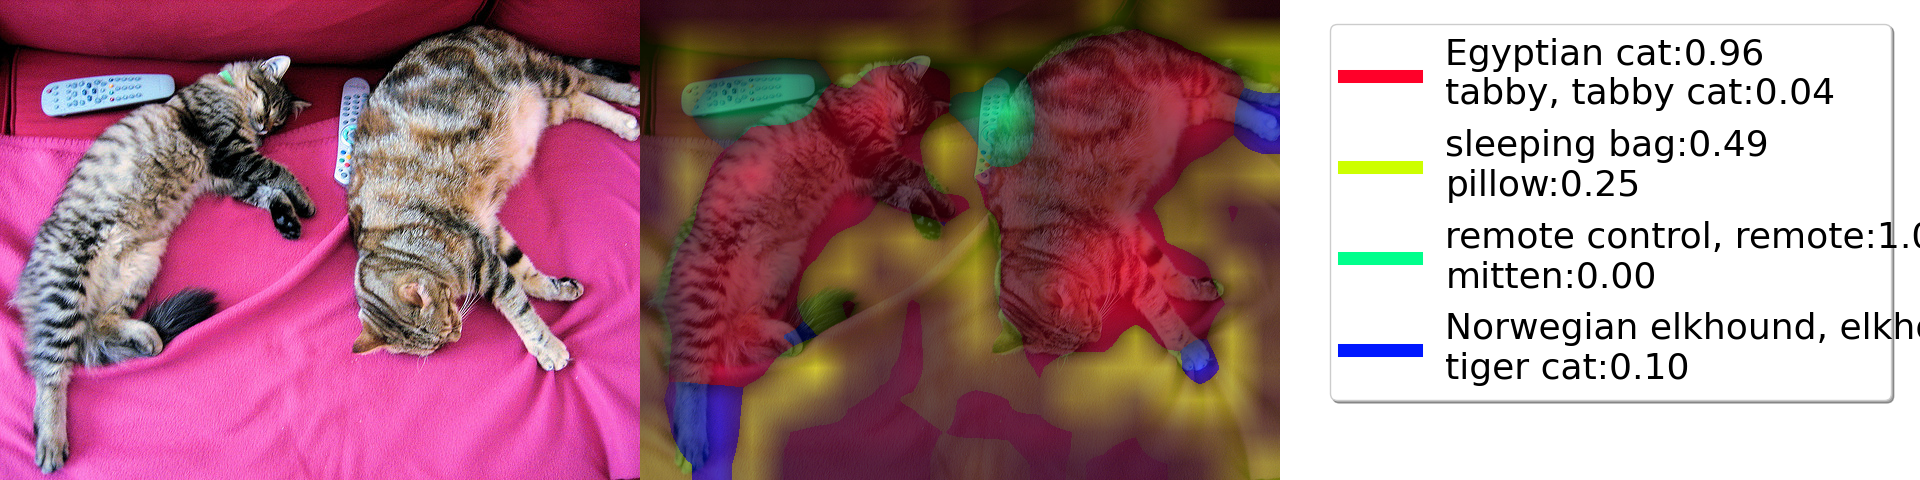

In [10]:
# The last layer in the Resnet Encoder:
target_layer = model.resnet.encoder.stages[-1].layers[-1]
display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer,
                          classifier=model.classifier,
                          img_pil=image,
                          img_tensor=img_tensor,
                          reshape_transform=None,
                          n_components=4,
                          top_k=2)))

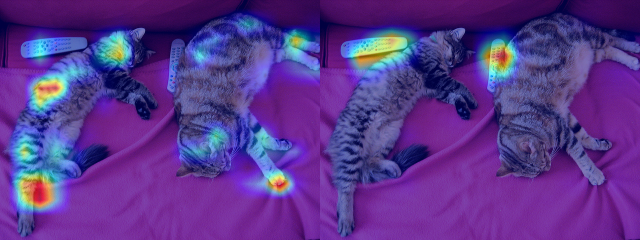

Predicted class 761: remote control, remote
Predicted class 282: tiger cat
Predicted class 285: Egyptian cat
Predicted class 281: tabby, tabby cat
Predicted class 721: pillow


In [11]:
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layer,
                      targets_for_gradcam=targets_for_gradcam,
                      reshape_transform=None)))
print_top_categories(model, img_tensor)

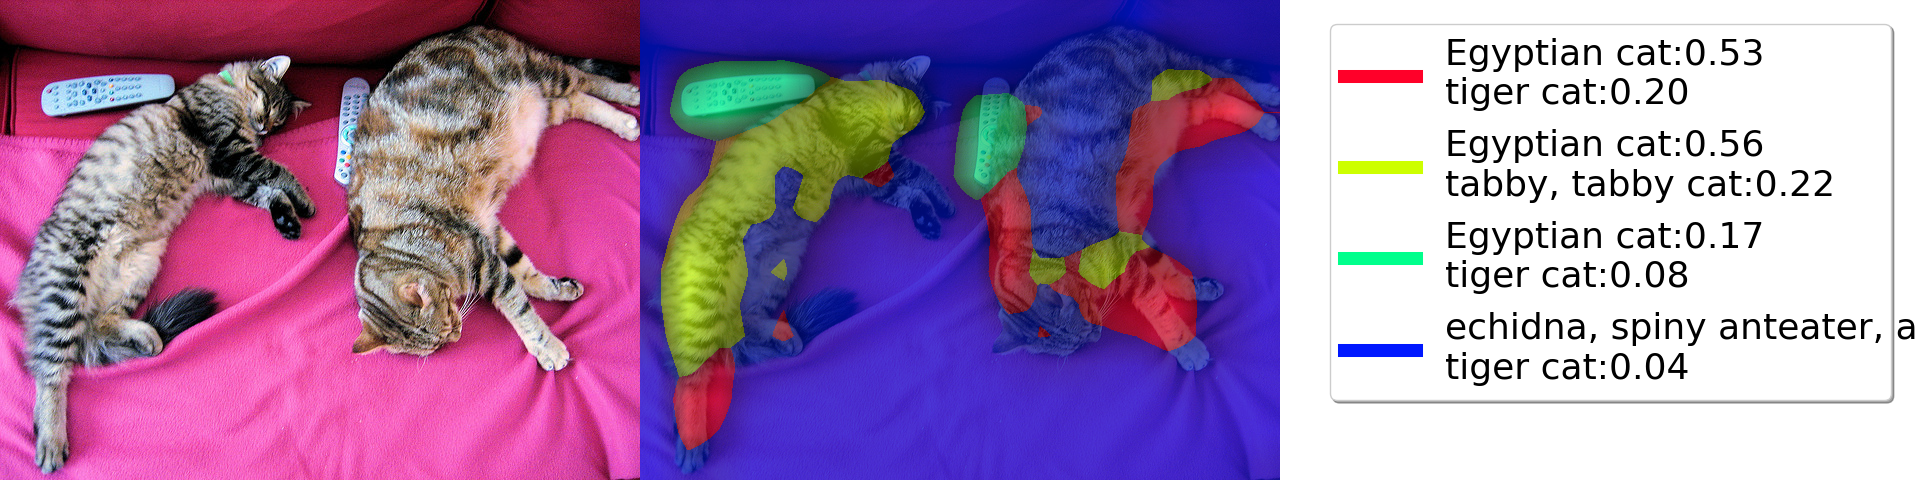

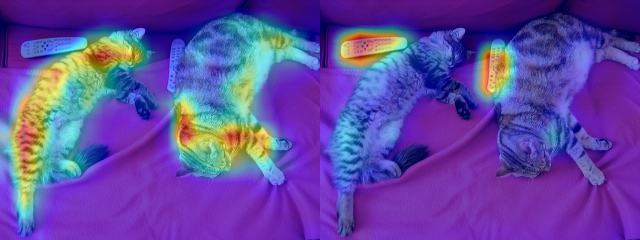

Predicted class 285: Egyptian cat
Predicted class 281: tabby, tabby cat
Predicted class 282: tiger cat
Predicted class 287: lynx, catamount
Predicted class 283: Persian cat


In [12]:
from transformers import SegformerForImageClassification
from functools import partial
def segformer_reshape_transform_huggingface(tensor, width, height):
    result = tensor.reshape(tensor.size(0),
                            height,
                            width,
                            tensor.size(2))
    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result
reshape_transform = partial(segformer_reshape_transform_huggingface,
                            width=img_tensor.shape[2]//32,
                            height=img_tensor.shape[1]//32)

model = SegformerForImageClassification.from_pretrained("nvidia/mit-b0")
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "Egyptian cat")),
                       ClassifierOutputTarget(category_name_to_index(model, "remote control, remote"))]
target_layer = model.segformer.encoder.layer_norm[-1]

display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer,
                          classifier=model.classifier,
                          img_pil=image,
                          img_tensor=img_tensor,
                          reshape_transform=reshape_transform,
                          n_components=4,
                          top_k=2)))
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layer,
                      targets_for_gradcam=targets_for_gradcam,
                      reshape_transform=reshape_transform)))
print_top_categories(model, img_tensor)

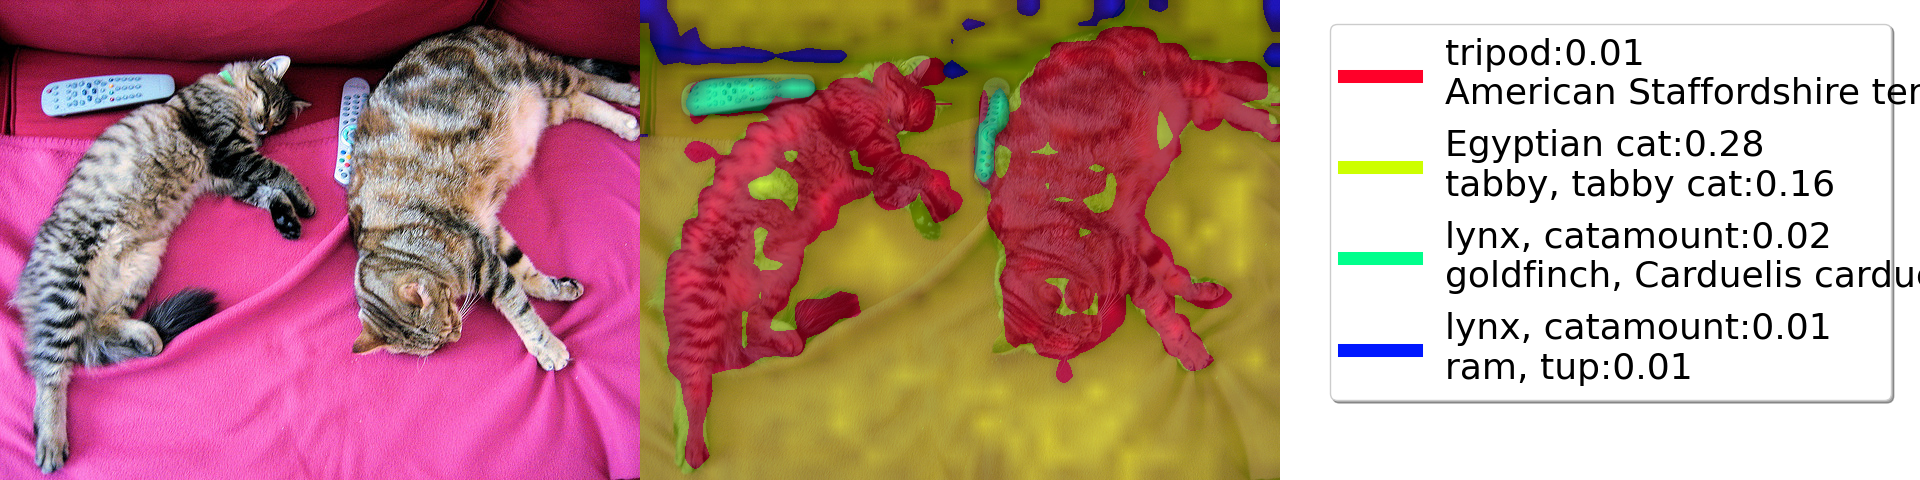

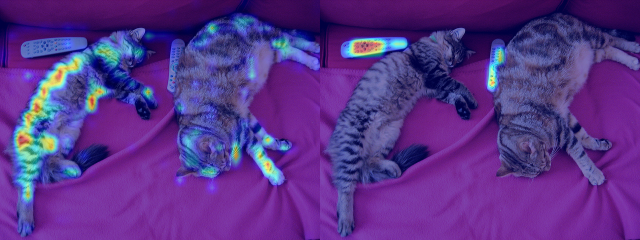

Predicted class 761: remote control, remote
Predicted class 281: tabby, tabby cat
Predicted class 282: tiger cat
Predicted class 285: Egyptian cat
Predicted class 287: lynx, catamount


In [13]:
from transformers import CvtForImageClassification
from functools import partial
def reshape_transform_cvt_huggingface(tensor, model, width, height):
    tensor = tensor[:, 1 :, :]
    tensor = tensor.reshape(tensor.size(0),
                            height,
                            width,
                            tensor.size(-1))
    
    # https://github.com/huggingface/transformers/blob/a2c90a7f7b1f8a2a8217c962a04a1a65638121d5/src/transformers/models/cvt/modeling_cvt.py#L699
    norm = model.layernorm(tensor)
    return norm.transpose(2, 3).transpose(1, 2)

def reshape_gradcam_transform_cvt_huggingface(tensor, model, width, height):
    tensor = tensor[:, 1 :, :]
    tensor = tensor.reshape(tensor.size(0),
                            height,
                            width,
                            tensor.size(-1))
    return tensor.transpose(2, 3).transpose(1, 2)


model = CvtForImageClassification.from_pretrained("microsoft/cvt-13")
reshape_transform = partial(reshape_transform_cvt_huggingface,
                            model=model,
                            width=img_tensor.shape[2]//16,
                            height=img_tensor.shape[1]//16)
reshape_transform_gradcam = partial(reshape_gradcam_transform_cvt_huggingface,
                            model=model,
                            width=img_tensor.shape[2]//16,
                            height=img_tensor.shape[1]//16)
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "Egyptian cat")),
                       ClassifierOutputTarget(category_name_to_index(model, "remote control, remote"))]
target_layer_dff = model.cvt.encoder.stages[-1].layers[-1]
target_layer_gradcam = model.cvt.encoder.stages[-1].layers[-2]

display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer_dff,
                          classifier=model.classifier,
                          img_pil=image,
                          img_tensor=img_tensor,
                          reshape_transform=reshape_transform,
                          n_components=4,
                          top_k=2)))
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layer_gradcam,
                      targets_for_gradcam=targets_for_gradcam,
                      reshape_transform=reshape_transform_gradcam)))
print_top_categories(model, img_tensor)

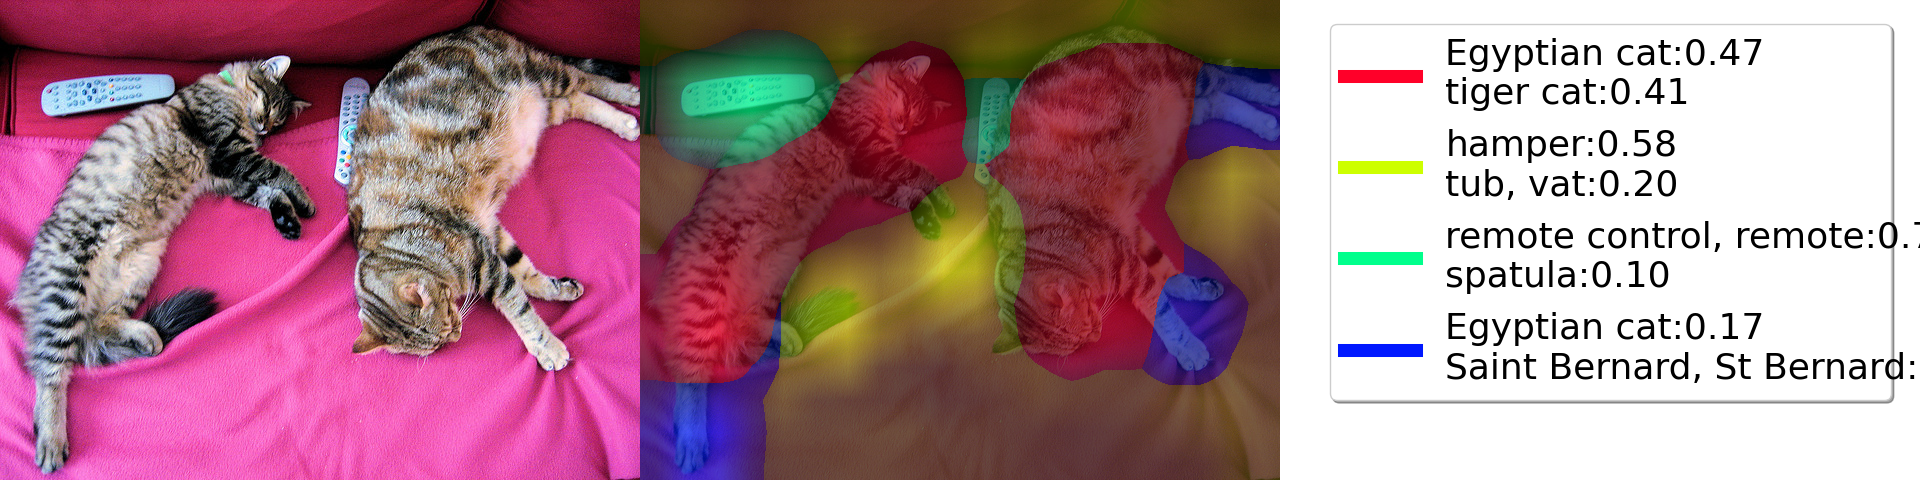

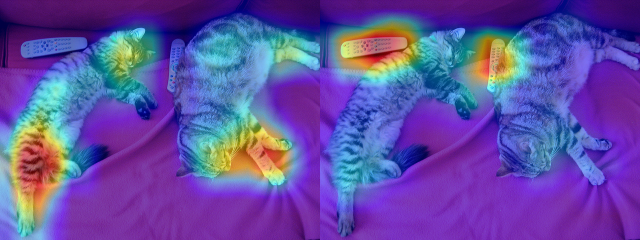

In [14]:
from transformers import RegNetForImageClassification
model = RegNetForImageClassification.from_pretrained("facebook/regnet-y-040")
target_layer = model.regnet.encoder.stages[-1]
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "Egyptian cat")),
                       ClassifierOutputTarget(category_name_to_index(model, "remote control, remote"))]

display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer,
                          classifier=model.classifier,
                          img_pil=image,
                          img_tensor=img_tensor,
                          reshape_transform=None,
                          n_components=4,
                          top_k=2)))
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layer,
                      targets_for_gradcam=targets_for_gradcam,
                      reshape_transform=None)))
#print_top_categories(model, tensor_resized)